# MECANISMO BIELA-MANIVELA

## PROBLEMAS VELOCIDAD Y ACELERACIÓN

### PASO 1: MATRIZ JACOBIANA 

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_4B, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [1]:
import numpy as np
import math as math
import array as arr
import pprint  # para depurar
import matplotlib.pyplot as plt  #Para graficas
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
#%matplotlib inline (Para notebook)



print ('BIELA-MANIVELA')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["XC"] = float (input ('Introduce coordenada en x del punto C:'))
meca["XA"] = 0
meca["YA"] = 0
meca["YB"] = float (input ('Introduce coordenada en y del punto B:'))
meca["YC"] = float (input ('Introduce coordenada en y del punto c: '))

# Defino posicion inicial:
q = np.array ([[0.1], [0.2], [1], [0.2], [meca["theta"]]])
print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((5,5))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,2] = meca["YB"] - meca["YC"]
    Jacob[2,3] = meca["XC"] - meca["XB"]

    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Jacob[3,4] = -meca["L1"]*math.sin(theta)
        Jacob[3,0] = 1
    else:
        Jacob[3,4] = meca["L1"]*math.cos(theta)
        Jacob[3,1] = 1

 
    Jacob[4,4] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((5,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 -meca["L2"]**2
    Phi[2] = (meca["XC"] - meca["XB"])*(Y2-meca["YB"]) - (meca["YC"]-meca["YB"])*(X2-meca["XB"])


    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        Phi[3] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[3] = Y1-meca["L1"]*math.sin(theta)
    
    
    
    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((5,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        theta = q[4]
       
        fi=Phi(q,meca)
      
        J = jacob_Phiq(q,meca)

        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1
        
    if (error > tolerancia):
        raise Exception ('No se puede alcanzar la posición')
        
    return q

q = resuelve_prob_posicion(q,meca)


BIELA-MANIVELA
Introduce longitud L1:1
Introduce longitud L2:2
Introduce angulo inicial theta:0.5
Introduce coordenada en x del punto B:2
Introduce coordenada en x del punto C:3
Introduce coordenada en y del punto B:0
Introduce coordenada en y del punto c: 0
q: [[0.1]
 [0.2]
 [1. ]
 [0.2]
 [0.5]]


### PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismo una vez sabemos su posición $q$ y la velocidad de los grados de libertad. 

Partimos de la ecuación:

$\Phi_q  =0 $

Derivando se obtiene:

$\Phi_q \dot{q} + \Phi_t = 0$

Siendo $\dot{q}$ el vector velocidad, $\Phi_q$ el jacobiano y $\Phi_t$ la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es $0$. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

De este modo la expresión quedaría:

$\Phi_q \dot{q} = -\Phi_t$

Este sistema de ecuaciones tiene infinitas soluciones y por tanto hay que ampliar añadiendo un dato conocido de velocidad, lo que se hace añadiendo una fila a la matriz de coeficientes del lado izquierdo y un dato a la columna del lado derecho de la ecuación por cada grado de libertad.

De esta forma llegamos a un sistema de ecuaciones lineal matricial de la forma:

$\mathbf{A} \mathbf{x} = \mathbf{b}$

Habría que multiplicar en ambas partes de la igualdad por la $A$ invertida en el lado izquierdo, del mismo modo que se hizo en el problema de posición. De esta manera quedaría:



$x = -A^{-1} b$

In [2]:
#PASO 2

def resuelve_prob_velocidad(q,meca):
    
    b = np.zeros ((5,1))
    #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
    b[4]=1
    qp = np.linalg.solve(jacob_Phiq(q,meca),b)
    #print ("qp=")
    #pprint.pprint(qp)
 
    return qp

resuelve_prob_velocidad (q,meca)

array([[ 0.47942554],
       [-0.87758256],
       [ 0.696111  ],
       [ 0.        ],
       [ 1.        ]])

### PASO 3: PROBLEMA ACELERACIÓN

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición$q$, la velocidad $\dot{q}$ y las aceleraciones de los grados de libertad. 

Partimos la ecuación que se obtiene tras derivar la ecuación inicial para el problema de velocidad, es decir:

$\Phi_q \dot{q} + \Phi_t = 0$

Se deriva por segunda vez:

$\dot{\Phi}_q \dot{q} + \Phi_q \ddot{q} + \dot{\Phi}_t = 0$

Despejamos $\Phi_q \ddot{q}$:

$\Phi_q \ddot{q} = -\dot{\Phi}_t - \dot{\Phi}_q  \dot{q}$


Siendo $\Phi_q$ el jacobiano, $\ddot{q}$ el vector aceleración, $\dot{q}$ el vector velocidad, $\dot{\Phi}_q$ la derivada del jacobiano respecto al tiempo y $\dot{\Phi}_t$ es la derivada de las ecuaciones de restricción con respecto al tiempo, cuyo valor es nulo. Es decir, tendríamos:

$\Phi_q \ddot{q} = - \dot{\Phi}_q  \dot{q}$

Del mismo modo que en el problema velocidad, llamando $b$ al conjunto formado por $\dot{\Phi}_q  \dot{q}$  llegamos a un sistema de ecuaciones lineal matricial:

$ \mathbf{A} \mathbf{x} = \mathbf{b}$

Y despejando la $x$:

$\mathbf{x} = \mathbf{A}^{-1} \mathbf{b}$


El vector velocidad será:

\begin{equation}
\mathbf{q_p} = 
\begin{bmatrix}
\dot{X}_1 \\
\dot{Y}_1 \\
\dot{X}_2 \\
\dot{Y}_2 \\
\dot{\theta}\\
\end{bmatrix}
\end{equation}

Por otro lado, para calcular la derivada del jacobiano solo tenemos en cuenta las filas que hacen referencia a las ecuaciones de las coordenadas independientes, ya que la última que añadimos para poder realizar los cálculos era adicional. Teniendo en cuenta esto, la derivada del jacobiano sería:

1. $Si ~~ \cos (θ) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & \dot{Y}_C-\dot{Y}_B & \dot{X}_B-\dot{X}_C & 0  \\
1 & 0 & 0 & 0 & \dot{\theta}L_1\cos(\theta)\
\end{bmatrix}
\end{equation}


2. $Si ~~ \cos (θ) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{\dot{\Phi}_q} = 
\begin{bmatrix}
2\dot{X}_1 & 2\dot{Y}_1 & 0 & 0 & 0  \\
-2(\dot{X}_2-\dot{X}_1) & -2(\dot{Y}_2-\dot{Y}_1) & 2(\dot{X}_2-\dot{X}_1) & 2(\dot{Y}_2-\dot{Y}_1) & 0\\
0 & 0 & \dot{Y}_C-\dot{Y}_B & \dot{X}_B-\dot{X}_C & 0  \\
0 & 1 & 0 & 0 & \dot{\theta}L_1\sin(theta)\\
\end{bmatrix}
\end{equation}



Como ya tenemos $\dot{\Phi}_q$ y $\dot{q}$, podemos calcular $b$. La última fila que añadimos es el valor de la aceleración angular, dato que sabemos de antemano. 


1. $Si ~~ \cos (\theta) < \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2 \\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) & -2\dot{Y}_1(\dot{Y}_2-\dot{Y}_1) & 2\dot{X}_2(\dot{X}_2-\dot{X}_1) & 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1) & 0\\
2\dot{X}_2^2 + 2\dot{Y}_2^2  \\
\dot{\theta}^2L_1\cos(\theta)\\
1\\
\end{bmatrix}
\end{equation}

2. $Si ~~ \cos (\theta) > \frac{1}{\sqrt{2}}$

\begin{equation}
\mathbf{b} = 
\begin{bmatrix}
2\dot{X}_1^2 + 2\dot{Y}_1^2 \\
-2\dot{X}_1(\dot{X}_2-\dot{X}_1) & -2\dot{Y}_1(\dot{Y}_2-\dot{Y}_1) & 2\dot{X}_2(\dot{X}_2-\dot{X}_1) & 2\dot{Y}_2(\dot{Y}_2-\dot{Y}_1) & 0\\
2\dot{X}_2^2 + 2\dot{Y}_2^2  \\
\dot{\theta}^2L_1\sin(\theta)\\
1\\
\end{bmatrix}
\end{equation}

In [3]:
#PASO 3

def resuelve_prob_aceleracion (q,meca):

    b=np.zeros ((5,1))
    qp = resuelve_prob_velocidad (q,meca)

    #Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    thetaq = qp[4]
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = -2*X1q*(X2q-X1q) - 2*Y1q*(Y2q-Y1q) + 2*X2q*(X2q-X1q) + 2*Y2q*(Y2q-Y1q)
    if (abs(math.cos(theta)) < (math.sqrt(2)/2) ):
        b[3] = thetaq**2 * (meca["L1"] * math.cos(theta))
    else: 
        b[3] =  thetaq**2 * (meca["L1"] * math.sin(theta))
    
    b[4] = 1 #Aceleracion conocida 
    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)

     
    return qpp

resuelve_prob_aceleracion(q, meca)

array([[-1.3570081 ],
       [ 0.39815702],
       [-1.87613915],
       [-0.        ],
       [-1.        ]])

### PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada $(X_1, ~ Y_1, ~ X_2 ~ e ~ Y_2)$.


VX1=
array([ 0.54630249,  0.54181733,  0.52843551,  0.50637675,  0.47600326,
        0.43781377,  0.39243535,  0.78183279,  0.85514401,  0.91441372,
        0.95866871,  0.98718231,  0.99948633,  0.99537874,  0.97492698,
        0.93846687,  0.88659709,  0.82016934,  0.74027437, -0.41598184,
       -0.45785141, -0.49220303, -0.51847265, -0.53622893, -0.5451803 ,
       -0.54517979, -0.5362274 , -0.51847012, -0.49219955, -0.45784703,
       -0.41597664, -0.74028425, -0.82017774, -0.88660388, -0.93847194,
       -0.97493025, -0.99538015, -0.99948586, -0.98717996, -0.95866453,
       -0.91440777, -0.85513639, -0.78182363,  0.39244094,  0.43781857,
        0.47600719,  0.50637976,  0.52843754,  0.54181836,  0.54630249])


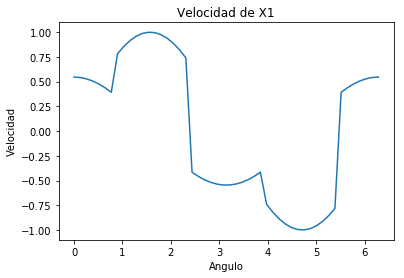

In [4]:
#PASO 4: VELOCIDAD DE X1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VX1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VX1 = np.append(VX1, qp[0])

        i=i+1
      
    print ("VX1=")
    pprint.pprint(VX1)
 
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY1=
array([-1.        , -0.99178998, -0.96729471, -0.92691642, -0.87131812,
       -0.80141273, -0.7183481 , -1.43113532, -1.5653306 , -1.67382308,
       -1.7548313 , -1.8070251 , -1.82954746, -1.82202856, -1.78459186,
       -1.71785208, -1.62290508, -1.5013099 , -1.35506314,  0.76144965,
        0.83809138,  0.9009716 ,  0.94905783,  0.98156048,  0.99794585,
        0.99794491,  0.98155767,  0.9490532 ,  0.90096523,  0.83808336,
        0.76144013,  1.35508122,  1.50132529,  1.62291752,  1.71786137,
        1.78459785,  1.82203114,  1.8295466 ,  1.8070208 ,  1.75482364,
        1.67381219,  1.56531666,  1.43111856, -0.71835832, -0.80142151,
       -0.87132533, -0.92692193, -0.96729844, -0.99179185, -1.        ])


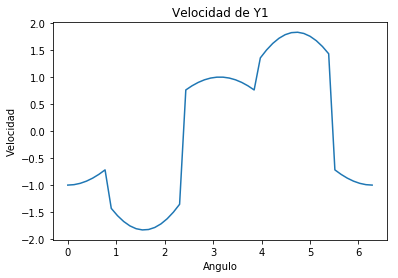

In [5]:
#PASO 4: VELOCIDAD DE Y1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VY1 = np.append(VY1, qp[1])

        i=i+1
      
    print ("VY1=")
    pprint.pprint(VY1)
 
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VX2=
array([ 0.79321425,  0.78670195,  0.76727195,  0.73524332,  0.69114195,
        0.635692  ,  0.56980395,  1.13519694,  1.24164255,  1.32770033,
        1.3919572 ,  1.43335807,  1.45122312,  1.44525903,  1.4155637 ,
        1.36262476,  1.28731145,  1.19086042,  1.0748554 , -0.60399272,
       -0.66478603, -0.71466352, -0.7528062 , -0.77858776, -0.79158488,
       -0.79158413, -0.77858553, -0.75280252, -0.71465846, -0.66477967,
       -0.60398516, -1.07486974, -1.19087262, -1.28732131, -1.36263213,
       -1.41556845, -1.44526107, -1.45122244, -1.43335466, -1.39195113,
       -1.32769169, -1.24163149, -1.13518364,  0.56981206,  0.63569897,
        0.69114767,  0.73524769,  0.76727491,  0.78670344,  0.79321425])


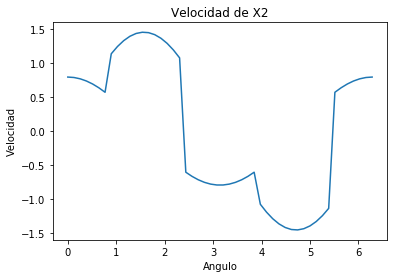

In [6]:
#PASO 4: VELOCIDAD DE X2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VX2 = np.append(VX2, qp[2])

        i=i+1
      
    print ("VX2=")
    pprint.pprint(VX2)
 
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY2=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


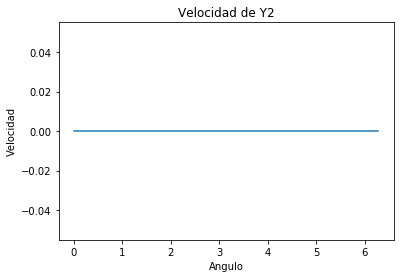

In [7]:
#PASO 4: VELOCIDAD DE Y2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VY2 = np.append(VY2, qp[3])

        i=i+1
      
    print ("VY2=")
    pprint.pprint(VY2)
 
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')

    plt.show()
    return 

grafica_velocidad (q,meca)

### PASO 5: GRÁFICAS ACELERACIONES

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

AX1=
array([-2.02587429, -1.92733445, -1.77423782, -1.57257669, -1.33120636,
       -1.06133711, -0.77587608, -1.40532095, -1.37353452, -1.31919459,
       -1.24319342, -1.14677895, -1.03153431, -0.89935183, -0.75240195,
       -0.59309759, -0.42405454, -0.2480485 , -0.06796948, -0.08775572,
       -0.28337129, -0.47181045, -0.6420526 , -0.78485401, -0.89332143,
       -0.96332277, -0.99370874, -0.98633171, -0.94586151, -0.87941117,
       -0.7959984 ,  1.41257826,  1.39228653,  1.3491334 ,  1.28382743,
        1.19744095,  1.09139243,  0.96742319,  0.82756882,  0.67412573,
        0.50961346,  0.33673331,  0.15832398, -1.53600526, -1.71485617,
       -1.86738348, -1.98260689, -2.05138765, -2.06705257, -2.02586626])


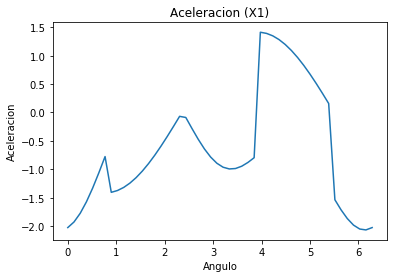

In [8]:
#PASO 5: ACELERACION DE X1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AX1 = np.zeros((50,0))

    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        
        
        AX1 = np.append(AX1, qpp[0])

        i=i+1
      
    print ("AX1=")
    pprint.pprint(AX1)	
 
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


AY1=
array([  1.        ,   0.86391252,   0.71363955,   0.55164858,
         0.38059952,   0.20330099,   0.02266426,  -2.9746552 ,
        -4.12189395,  -5.17313696,  -6.06449483,  -6.74447885,
        -7.177257  ,  -7.34485574,  -7.24816602,  -6.90669032,
        -6.35705064,  -5.65035843,  -4.84862244,  -1.40967371,
        -1.38362125,  -1.33484967,  -1.26415978,  -1.17271233,
        -1.06200889,  -0.93386721,  -0.79039139,  -0.63393729,
        -0.46707392,  -0.29254117,  -0.11320488,  -7.55887962,
        -8.65309669,  -9.60295876, -10.34246496, -10.81738736,
       -10.98891416, -10.83631563, -10.35845619,  -9.57405125,
        -8.52064893,  -7.2524    ,  -5.83675806,   1.41403161,
         1.39952147,   1.36203112,   1.30217615,   1.22093939,
         1.11965474,   0.99998531])


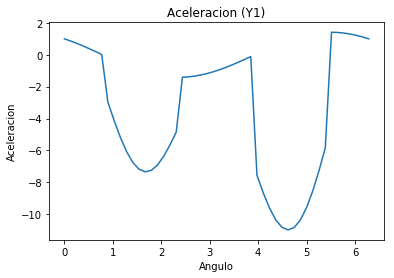

In [9]:
#PASO 5: ACELERACION DE Y1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AY1 = np.zeros((50,0))

    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        
        
        AY1 = np.append(AY1, qpp[1])

        i=i+1
      
    print ("AY1=")
    pprint.pprint(AY1)	
 
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AX2=
array([-2.81920009, -2.67812333, -2.46170106, -2.17824997, -1.8400158 ,
       -1.46247568, -1.06343491, -1.78998058, -1.69464682, -1.57276552,
       -1.42844365, -1.26571522, -1.08836617, -0.89979934, -0.70294649,
       -0.50023094, -0.29358067, -0.0844883 ,  0.12588911, -0.0565046 ,
       -0.32553859, -0.58577186, -0.82207768, -1.02174613, -1.17527045,
       -1.27691045, -1.32499739, -1.32196133, -1.27408068, -1.19097164,
       -1.08485276,  2.27560445,  2.29723289,  2.28103812,  2.22500983,
        2.12816748,  1.99070067,  1.81405768,  1.60097455,  1.35544094,
        1.08260254,  0.78860364,  0.48037745, -2.16711708, -2.41136335,
       -2.6185268 , -2.77359985, -2.86411313, -2.88098926, -2.81918844])


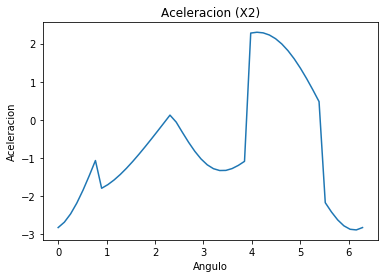

In [10]:
#PASO 5: ACELERACION DE X2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AX2 = np.zeros((50,0))

    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        
        
        AX2 = np.append(AX2, qpp[2])

        i=i+1
      
    print ("AX2=")
    pprint.pprint(AX2)	
 
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)

AY2=
array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.])


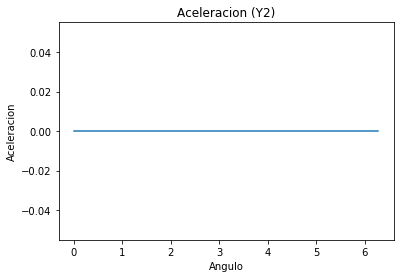

In [11]:
#PASO 5: ACELERACION DE Y2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
 
    
    AY2 = np.zeros((50,0))

    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        
        
        AY2 = np.append(AY2, qpp[3])

        i=i+1
      
    print ("AY2=")
    pprint.pprint(AY2)	
 
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)